# GHP Cpnstruction with Duration Matching

In [2]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
erk.bond_cash_flows(3,100,0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [4]:
erk.bond_price(20, 1000, 0.05,2,0.04)

0    1136.777396
dtype: float64

In [5]:
erk.bond_price(20, 1000, 0.05,2,0.05)

0    1000.0
dtype: float64

In [6]:
rates = np.linspace(0.01, 0.10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [7]:
prices = [erk.bond_price(10, 1000, 0.05, 2, rate) for rate in rates]
prices

[0    1379.748383
 dtype: float64,
 0    1326.762928
 dtype: float64,
 0    1276.163298
 dtype: float64,
 0    1227.833538
 dtype: float64,
 0    1181.663651
 dtype: float64,
 0    1137.549279
 dtype: float64,
 0    1095.3914
 dtype: float64,
 0    1055.096038
 dtype: float64,
 0    1016.573997
 dtype: float64,
 0    979.740605
 dtype: float64,
 0    944.515473
 dtype: float64,
 0    910.822268
 dtype: float64,
 0    878.588497
 dtype: float64,
 0    847.745306
 dtype: float64,
 0    818.227287
 dtype: float64,
 0    789.972298
 dtype: float64,
 0    762.92129
 dtype: float64,
 0    737.018147
 dtype: float64,
 0    712.209532
 dtype: float64,
 0    688.444741
 dtype: float64]

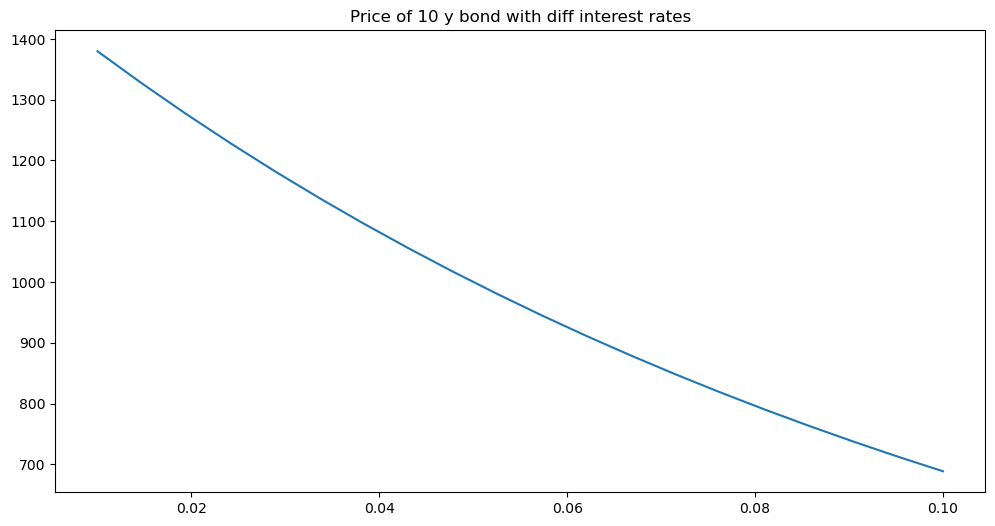

In [8]:
pd.DataFrame(data=prices, index=rates).plot(title="Price of 10 y bond with diff interest rates", legend=False, figsize=(12,6))
plt.show()

In [9]:
cf = erk.bond_cash_flows(3, 1000, 0.06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [10]:
discounts = erk.discount(cf.index,0.06/2)
discounts

,0
1,0.970874
2,0.942596
3,0.915142
4,0.888487
5,0.862609
6,0.837484


In [11]:
dcf = discounts * cf
dcf

,0,1,2,3,4,5,6
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
weights = dcf/dcf.sum()
weights

,0,1,2,3,4,5,6
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
(cf.index * weights).sum()

ValueError: Unable to coerce to Series, length must be 7: given 6

In [ ]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, 0.06, 2), 0.06/2)

5.579707187194534

# Duarion Matching
If you can match the Macaulay duration of the cash flow with the one of the liability, you can get a portfolio which have a same sensityvity as the liability

In [ ]:
liabilities = pd.Series(data=[100000, 100000], index=[10,12])
erk.macaulay_duration(liabilities, 0.04)

TypeError: Axis must be specified when shapes of a and weights differ.

In [ ]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, 0.05, 1),0.04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, 0.05, 1),0.04)

In [ ]:
md_10, md_20

(8.190898824083233, 13.544718122145921)

In this case, we need to set the weight to match the duration of the portfolio with the one of the liability.

So that we need to find $w_s$ which satisfies
$$w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96$$
In general, 
$$w_s \times d_s + (1-w_s) \times d_l = d_t$$
where $d_s, d_l$ and $d_t$ are the durations of a short bond, a long bond and a liability.

Therefore, we get
$$w_s = \frac{d_l - d_t}{d_l-d_s}$$


In [ ]:
short_bond = erk.bond_cash_flows(10,1000, 0.05, 1)
long_bond = erk.bond_cash_flows(20,1000, 0.05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_s

0.48263092069478974

In [ ]:
p_short = erk.bond_price(10, 1000, 0.05, 1, 0.04)
p_long = erk.bond_price(20, 1000, 0.05, 1, 0.04)
a_0 = 130000
p_flows = pd.concat([a_0 * w_s * short_bond / p_short, a_0 * (1-w_s) * long_bond /p_long])
erk.macaulay_duration(p_flows, 0.04)


10.960799385088393

In [ ]:
erk.macaulay_duration(liabilities, 0.04)

10.960799385088393

In [ ]:
cfr = erk.funding_ratio(p_flows, liabilities, 0.04)
cfr

0.9998760012192478

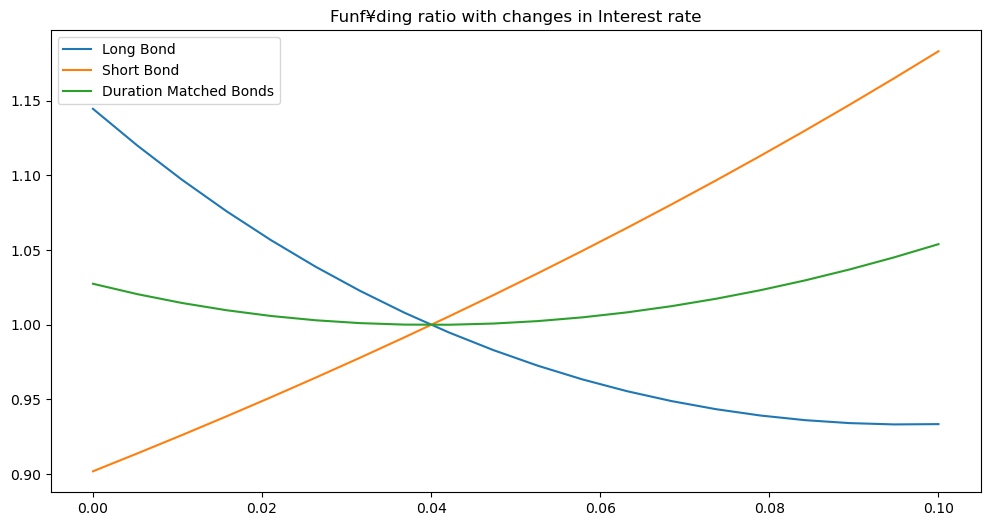

In [ ]:
rates = np.linspace(0,0.1,20)
lb_assets = a_0 * long_bond/p_long
sb_assets = a_0 * short_bond/p_short
fr_change = pd.DataFrame({
    "Long Bond": [erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    "Short Bond": [erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    "Duration Matched Bonds": [erk.funding_ratio(p_flows, liabilities, r) for r in rates]
}   ,index = rates
)

fr_change.plot(title="Funf¥ding ratio with changes in Interest rate", figsize=(12,6))
plt.show()